## Importing required modules

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.applications.vgg19 import VGG19
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Dense, Flatten, Conv2D, ZeroPadding2D, MaxPool2D, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Initialize Image Data Generator

In [2]:
data_generator = ImageDataGenerator(rescale=1/255.)

train_data = data_generator.flow_from_directory(
    directory='augmented_data_split/train',
    shuffle=False,
    batch_size=32,
    target_size=(180,180),
    class_mode='binary'
)

test_data = data_generator.flow_from_directory(
    directory='augmented_data_split/test',
    shuffle=False,
    batch_size=32,
    target_size=(180,180),
    class_mode='binary'
)

val_data = data_generator.flow_from_directory(
    directory='augmented_data_split/val',
    shuffle=False,
    batch_size=32,
    target_size=(180,180),
    class_mode='binary'
)

Found 1384 images belonging to 2 classes.


Found 175 images belonging to 2 classes.
Found 172 images belonging to 2 classes.


#### Define a function to ceil or floor the predicted value based on threshold

In [3]:
def threshold(pred):
    pred = list(map(lambda x : 1 if x > 0.7 else 0, pred))
    return pred

## VGG-19 Model

#### Model Initialization

In [8]:
# Initialize VGG-19
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(180,180,3))
for layer in vgg.layers:
    layer.trainable = False

# Sequential Model
vgg_model = Sequential()

# Start with VGG-19
vgg_model.add(vgg)

# Flatten
vgg_model.add(Flatten())

# Fully Connected Neural Network
vgg_model.add(Dense(64))
vgg_model.add(Dense(1, activation='sigmoid'))

# Compile for Binary Classification
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display Model Architecture
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                819264    
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 20,843,713
Trainable params: 819,329
Non-trainable params: 20,024,384
_________________________________________________________________


#### Model Training

In [9]:
# Model Checkpoint to Save the Best Model
checkpoint = ModelCheckpoint(filepath='models/vgg19_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)

# Start Training
vgg_model_history = vgg_model.fit(train_data, epochs=15, validation_data=val_data, callbacks=[checkpoint])

Epoch 1/15
44/44 [==============================] - ETA: 0s - loss: 2.6621 - accuracy: 0.6445
Epoch 1: val_accuracy improved from -inf to 0.73837, saving model to models\vgg19_model.hdf5
44/44 [==============================] - 13s 228ms/step - loss: 2.6621 - accuracy: 0.6445 - val_loss: 1.0216 - val_accuracy: 0.7384
Epoch 2/15
44/44 [==============================] - ETA: 0s - loss: 0.8842 - accuracy: 0.7825
Epoch 2: val_accuracy did not improve from 0.73837
44/44 [==============================] - 6s 145ms/step - loss: 0.8842 - accuracy: 0.7825 - val_loss: 2.2965 - val_accuracy: 0.5872
Epoch 3/15
44/44 [==============================] - ETA: 0s - loss: 0.5186 - accuracy: 0.8483
Epoch 3: val_accuracy improved from 0.73837 to 0.82558, saving model to models\vgg19_model.hdf5
44/44 [==============================] - 7s 149ms/step - loss: 0.5186 - accuracy: 0.8483 - val_loss: 0.5759 - val_accuracy: 0.8256
Epoch 4/15
44/44 [==============================] - ETA: 0s - loss: 0.1661 - accurac

#### Accuracy and Loss Graphs

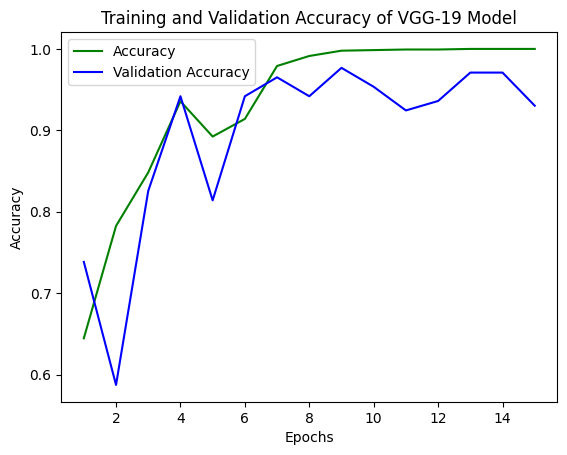

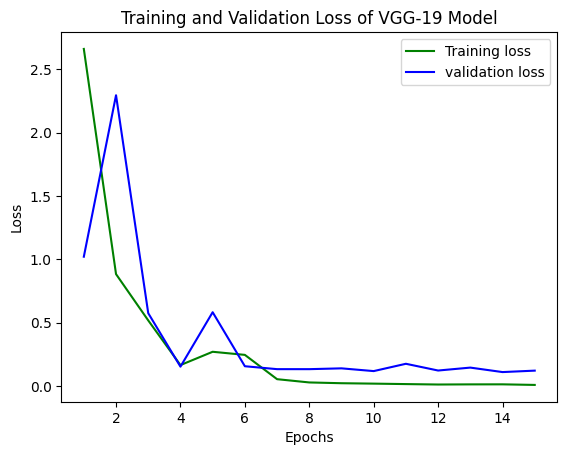

In [10]:
# Training and Validation Accuracy Graph
train = vgg_model_history.history['accuracy']
val = vgg_model_history.history['val_accuracy']
epochs = range(1,16)
plt.plot(epochs, train, 'g', label='Accuracy')
plt.plot(epochs, val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG-19 Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training and Validation Loss Graph
train = vgg_model_history.history['loss']
val = vgg_model_history.history['val_loss']
epochs = range(1,16)
plt.plot(epochs, train, 'g', label='Training loss')
plt.plot(epochs, val, 'b', label='validation loss')
plt.title('Training and Validation Loss of VGG-19 Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Model Evaluation

6/6 [==============================] - 1s 147ms/step

VGG-19 Model Evaluation on Training Data
44/44 [==============================] - 9s 193ms/step - loss: 0.0322 - accuracy: 0.9971

VGG-19 Model Evaluation on Testing Data
6/6 [==============================] - 1s 139ms/step - loss: 0.1390 - accuracy: 0.9486

VGG-19 Model Evaluation on Validation Data
6/6 [==============================] - 1s 134ms/step - loss: 0.1403 - accuracy: 0.9767

Classification Report for Train Data on VGG-19 Model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       678
           1       1.00      1.00      1.00       706

    accuracy                           1.00      1384
   macro avg       1.00      1.00      1.00      1384
weighted avg       1.00      1.00      1.00      1384


Classification Report for Testing Data on VGG-19 Model
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        86
           

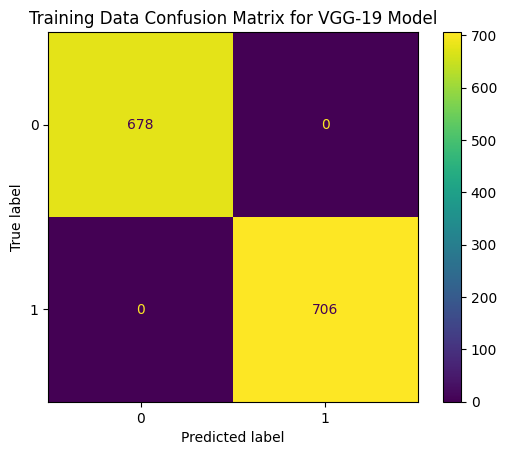

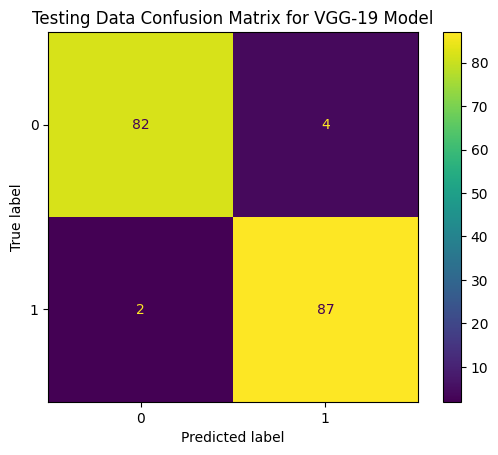

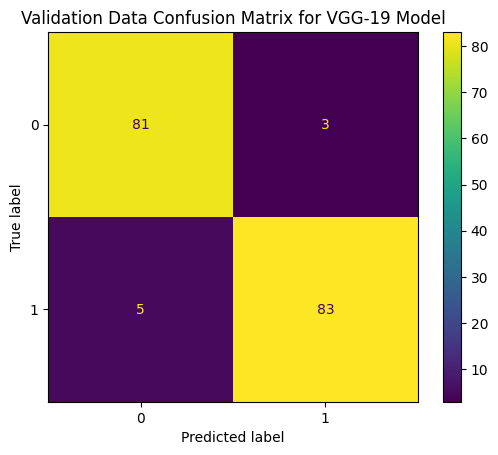

In [11]:
# Load best model
vgg_model = load_model('models/vgg19_model.hdf5')

# Make Predictions on training testing and validation data
train_pred = threshold(vgg_model.predict(train_data))
test_pred = threshold(vgg_model.predict(test_data))
val_pred = threshold(vgg_model.predict(val_data))

# Evaluate to check accuracy and loss on training testing and validation data
print('\nVGG-19 Model Evaluation on Training Data')
vgg_model.evaluate(train_data)
print('\nVGG-19 Model Evaluation on Testing Data')
vgg_model.evaluate(test_data)
print('\nVGG-19 Model Evaluation on Validation Data')
vgg_model.evaluate(val_data)

# Print Classification Reports
print('\nClassification Report for Train Data on VGG-19 Model')
print(classification_report(train_data.labels, train_pred))
print('\nClassification Report for Testing Data on VGG-19 Model')
print(classification_report(test_data.labels, test_pred))
print('\nClassification Report for Validation Data on VGG-19 Model')
print(classification_report(val_data.labels, val_pred))

# Display Confusion Matrices
print('\nConfusion Matrices:')

cm = confusion_matrix(train_data.labels, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Training Data Confusion Matrix for VGG-19 Model')
plt.show()

cm = confusion_matrix(test_data.labels, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Testing Data Confusion Matrix for VGG-19 Model')
plt.show()

cm = confusion_matrix(val_data.labels, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Validation Data Confusion Matrix for VGG-19 Model')
plt.show()

## Inception ResNet V2 Model

#### Model Initialization

In [12]:
# Initialize Inception Resnet V2
inception_resnet = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(180,180,3))
for layer in inception_resnet.layers:
    layer.trainable = False

# Sequential Model
inception_resnet_model = Sequential()

# Start with Inception Resnet V2
inception_resnet_model.add(inception_resnet)

# Flatten
inception_resnet_model.add(Flatten())

# Fully Connected Neural Network
inception_resnet_model.add(Dense(64))
inception_resnet_model.add(Dense(1, activation='sigmoid'))

# Compile for Binary Classification
inception_resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display Model Architecture
inception_resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 24576)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                1572928   
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 55,909,729
Trainable params: 1,572,993
Non-trainable params: 54,336,736
_________________________________________________________________


#### Model Training

In [13]:
# Model Checkpoint to Save the Best Model
checkpoint = ModelCheckpoint(filepath='models/inception_resnet_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)

# Start Training
inception_resnet_model_history = inception_resnet_model.fit(train_data, epochs=15, validation_data=val_data, callbacks=[checkpoint])

Epoch 1/15
44/44 [==============================] - ETA: 0s - loss: 24.3524 - accuracy: 0.6777
Epoch 1: val_accuracy improved from -inf to 0.78488, saving model to models\inception_resnet_model.hdf5
44/44 [==============================] - 28s 362ms/step - loss: 24.3524 - accuracy: 0.6777 - val_loss: 9.8955 - val_accuracy: 0.7849
Epoch 2/15
44/44 [==============================] - ETA: 0s - loss: 4.9226 - accuracy: 0.8605
Epoch 2: val_accuracy improved from 0.78488 to 0.79651, saving model to models\inception_resnet_model.hdf5
44/44 [==============================] - 9s 212ms/step - loss: 4.9226 - accuracy: 0.8605 - val_loss: 8.8589 - val_accuracy: 0.7965
Epoch 3/15
44/44 [==============================] - ETA: 0s - loss: 2.7049 - accuracy: 0.8786
Epoch 3: val_accuracy improved from 0.79651 to 0.86628, saving model to models\inception_resnet_model.hdf5
44/44 [==============================] - 9s 210ms/step - loss: 2.7049 - accuracy: 0.8786 - val_loss: 3.5988 - val_accuracy: 0.8663
Epoc

#### Accuracy and Loss Graphs

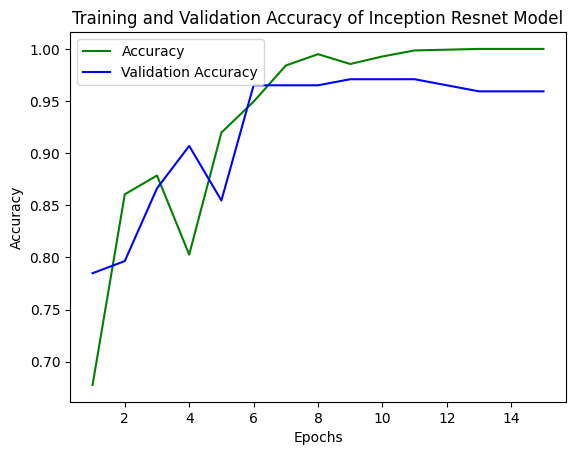

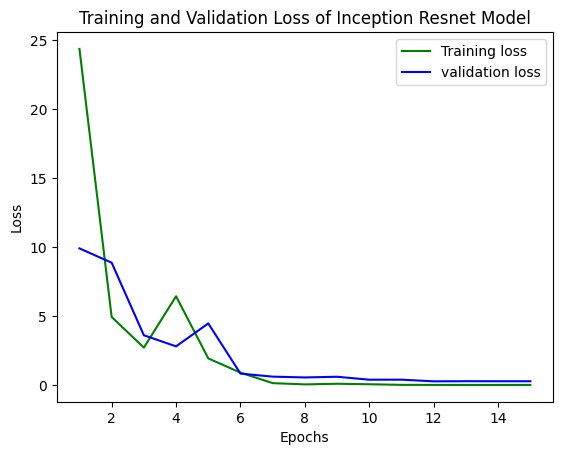

In [14]:
# Training and Validation Accuracy Graph
train = inception_resnet_model_history.history['accuracy']
val = inception_resnet_model_history.history['val_accuracy']
epochs = range(1,16)
plt.plot(epochs, train, 'g', label='Accuracy')
plt.plot(epochs, val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of Inception Resnet Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training and Validation Loss Graph
train = inception_resnet_model_history.history['loss']
val = inception_resnet_model_history.history['val_loss']
epochs = range(1,16)
plt.plot(epochs, train, 'g', label='Training loss')
plt.plot(epochs, val, 'b', label='validation loss')
plt.title('Training and Validation Loss of Inception Resnet Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Model Evaluation

6/6 [==============================] - 1s 152ms/step

Inception Resnet Model Evaluation on Training Data
44/44 [==============================] - 11s 156ms/step - loss: 0.0292 - accuracy: 0.9928

Inception Resnet Model Evaluation on Testing Data
6/6 [==============================] - 1s 147ms/step - loss: 0.4475 - accuracy: 0.9486

Inception Resnet Model Evaluation on Validation Data
6/6 [==============================] - 1s 152ms/step - loss: 0.5914 - accuracy: 0.9709

Classification Report for Train Data on Inception Resnet Model
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       678
           1       1.00      0.98      0.99       706

    accuracy                           0.99      1384
   macro avg       0.99      0.99      0.99      1384
weighted avg       0.99      0.99      0.99      1384


Classification Report for Testing Data on Inception Resnet Model
              precision    recall  f1-score   support

           0  

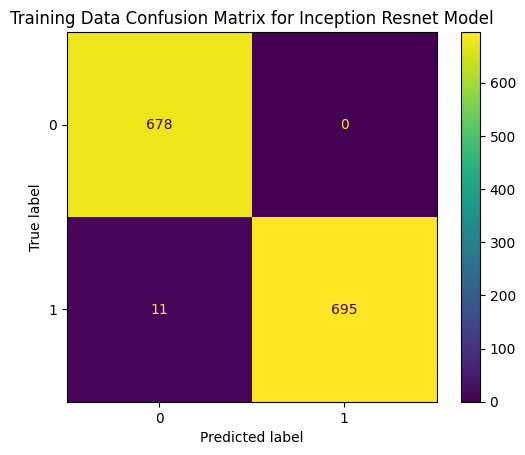

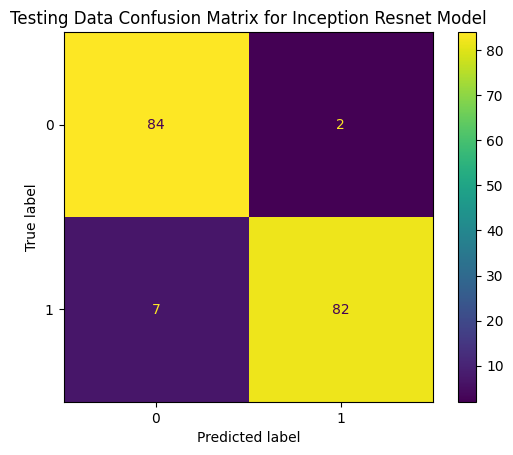

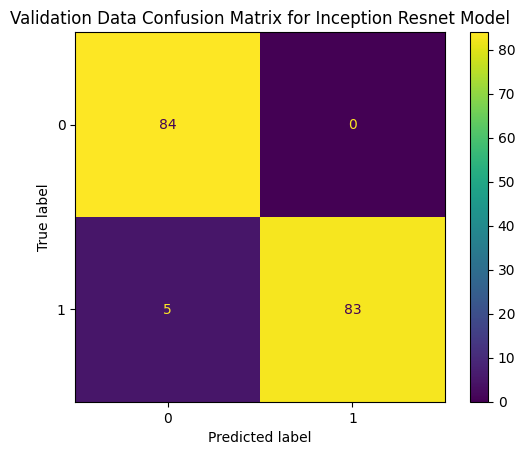

In [15]:
# Load best model
inception_resnet_model = load_model('models/inception_resnet_model.hdf5')

# Make Predictions on training testing and validation data
train_pred = threshold(inception_resnet_model.predict(train_data))
test_pred = threshold(inception_resnet_model.predict(test_data))
val_pred = threshold(inception_resnet_model.predict(val_data))

# Evaluate to check accuracy and loss on training testing and validation data
print('\nInception Resnet Model Evaluation on Training Data')
inception_resnet_model.evaluate(train_data)
print('\nInception Resnet Model Evaluation on Testing Data')
inception_resnet_model.evaluate(test_data)
print('\nInception Resnet Model Evaluation on Validation Data')
inception_resnet_model.evaluate(val_data)

# Print Classification Reports
print('\nClassification Report for Train Data on Inception Resnet Model')
print(classification_report(train_data.labels, train_pred))
print('\nClassification Report for Testing Data on Inception Resnet Model')
print(classification_report(test_data.labels, test_pred))
print('\nClassification Report for Validation Data on Inception Resnet Model')
print(classification_report(val_data.labels, val_pred))

# Display Confusion Matrices
print('\nConfusion Matrices:')

cm = confusion_matrix(train_data.labels, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Training Data Confusion Matrix for Inception Resnet Model')
plt.show()

cm = confusion_matrix(test_data.labels, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Testing Data Confusion Matrix for Inception Resnet Model')
plt.show()

cm = confusion_matrix(val_data.labels, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Validation Data Confusion Matrix for Inception Resnet Model')
plt.show()